In [2]:
import gym
import numpy as np
import torch
import torch.nn as nn 
import torch.nn.functional as F
from torch.distributions import Categorical

import sys
# insert at 1, 0 is the script path (or '' in REPL)
sys.path.insert(1, '../../Envs/gym-grid/gym_grid/envs/')

import gridworld as GW
from importlib import reload

import matplotlib.pyplot as plt

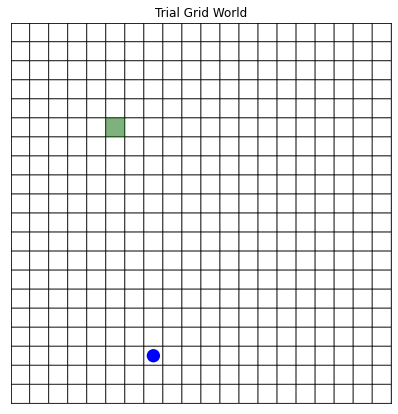

In [3]:
reload(GW)
env = GW.GridWorld4()
#env = gym.make('gym_grid:gridworld-v1')
data_col = [[],[],[]]

# check functions of gridworld gym env
env.reset()

def get_action(s):
    return np.random.choice(len(env.action_list))

In [5]:
def get_samples(maxsteps):
    data_col = [[],[],[]]
    onehot_a = np.zeros(env.action_space.n)
    env.reset()
    for step in range(maxsteps):
        s = env.get_state()
        state = env.get_observation()

        
        action = get_action(s)
        
        onehot_a[:]=0
        onehot_a[action] = 1
    
        s_prime, r, done, __ = env.step(action)
        next_state = env.get_observation()

        data_col[0].append(state)
        data_col[1].append(onehot_a.copy())
        data_col[2].append(next_state)

        #env.render(0.05)

        if step == maxsteps-1 or done:
            #plt.show(block=True)
            pass

        if done:
            env.reset()
            #break
    return data_col

class SRNet(nn.Module):
    def __init__(self):
        super(SRNet, self).__init__()
        
        self.rep_layer_dims = 400
        hidden_units_sr=(self.rep_layer_dims*4,)
        in_channels = 3
        num_actions = 4
        
        self.conv1 = nn.Conv2d(in_channels, 32, kernel_size=4, stride=2)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=4, stride=1)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=2, stride=1)
        self.rep   = nn.Linear(5*5*32,self.rep_layer_dims)
        
        self.lin1  = nn.Linear(self.rep_layer_dims+num_actions, 5*5*32)
        #self.lin2  = nn.Linear(5*5*32, 5*5*32)
        self.dconv1= nn.ConvTranspose2d(32,32, kernel_size=2, stride=1)
        self.dconv2= nn.ConvTranspose2d(32,32, kernel_size=4, stride=1)
        self.dconv3= nn.ConvTranspose2d(32,in_channels, kernel_size=4, stride=2)
        
        
        self.sr    = nn.Linear(self.rep_layer_dims, self.rep_layer_dims)
        
    def forward(self, state, action):
        action = torch.Tensor(action)#torch.unsqueeze(torch.Tensor(action),-1)
        x = torch.Tensor(state)
        batch_size = x.shape[0]
        
        # encode
        x = F.relu(self.conv1(x))
        
        x = F.relu(self.conv2(x))
        
        x = F.relu(self.conv3(x))
        
        
        # cast x into correct shape
        x = x.view(batch_size,32*5*5)
        
        
        # get latent representation
        phi = F.relu(self.rep(x))
        
        # get SR
        psi = F.relu(self.sr(phi)) ## no relu 
        
        x = torch.cat((phi, action), 1)
        x = F.relu(self.lin1(x))
        
        #x = F.relu(self.lin2(x))
        
        # cast x into correct shape 
        x = x.view(batch_size, 32, 5, 5)
        
        # decode
        x = F.relu(self.dconv1(x))
        
        x = F.relu(self.dconv2(x))
        
        reconstruct = F.tanh(self.dconv3(x))
        
        return phi, psi, reconstruct
    

class FCNet(nn.Module):
    def __init__(self):
        super(FCNet, self).__init__()
        num_actions = 4
        self.lin1 = nn.Linear(400, 300)
        self.lin2 = nn.Linear(300, 200)
        self.lin3 = nn.Linear(200, 100)
        self.rep  = nn.Linear(100, 400)
        
        self.rlin1= nn.Linear(400+num_actions,200)
        self.rlin2= nn.Linear(200,300)
        self.rlin3= nn.Linear(300,400)
        
        
        self.sr    = nn.Linear(400,400)
    
    def forward(self, state, action):
        a = torch.Tensor(action)
        x = torch.Tensor(state)
        
        x = F.relu(self.lin1(x))
        
        x = F.relu(self.lin2(x))
        
        x = F.relu(self.lin3(x))
        
        phi = F.relu(self.rep(x))
        
        psi = F.relu(self.sr(phi))
        
        x = torch.cat((phi, a), -1)
        x = F.relu(self.rlin1(x))
        
        x = F.relu(self.rlin2(x))
        
        reconst = F.tanh(self.rlin3(x))
        
        return phi, psi, reconst
    

def plot_phi(phi):
    data = phi[0].detach().numpy()
    print(data.shape)
    plt.imshow(data, aspect='auto')
    plt.show()
    
def plot_frames(obsr):
    obs = obsr[0]
    
    fig, axs = plt.subplots(1,3, sharey = True)
    cmap = 'bone_r'
    titles = ['Grid', 'Reward', 'Agent']
    for i in range(3):
        ax = axs[i]
        pcm = ax.pcolor(obs[i], cmap=cmap, vmin=0, vmax=1)
        fig.colorbar(pcm, ax=ax, shrink=0.4)
        ax.set_title(titles[i])
        ax.invert_yaxis()
        ax.set_aspect('equal')
        ax.get_xaxis().set_ticks([])
        ax.get_yaxis().set_ticks([])
    
    plt.show()

## Conv AutoEncoder

In [6]:
testsr = SRNet()
loss = nn.MSELoss(reduction='mean')
#print(testsr)
loss_tracker = []

optimizer = torch.optim.Adam(testsr.parameters(), lr = 0.01)
training_cycles = 300
# get samples from env
[states, actions, n_states] = get_samples(100)

for train in range(training_cycles):
    
    # get guesses from network 
    phi, psi, reconst = testsr(states, actions)

    # compute loss
    optimizer.zero_grad()
    output = loss(reconst, torch.Tensor(n_states))
    loss_tracker.append(output)
    output.backward()
    optimizer.step()
    
    print(f'Training Cycle:{train} Loss:{output}')

/home/annik/.local/lib/python3.8/site-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/annik/.local/lib/python3.8/site-packages/torch/autograd/__init__.py:130: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  Variable._execution_engine.run_backward(


Training Cycle:0 Loss:0.009250921197235584
Training Cycle:1 Loss:0.020168082788586617
Training Cycle:2 Loss:0.005544543266296387
Training Cycle:3 Loss:0.005316335242241621
Training Cycle:4 Loss:0.004904261324554682
Training Cycle:5 Loss:0.00421525863930583
Training Cycle:6 Loss:0.003424354363232851
Training Cycle:7 Loss:0.0027610668912529945
Training Cycle:8 Loss:0.002277134219184518
Training Cycle:9 Loss:0.00207565538585186
Training Cycle:10 Loss:0.0019762865267693996
Training Cycle:11 Loss:0.0019091838039457798
Training Cycle:12 Loss:0.0018578021554276347
Training Cycle:13 Loss:0.0017779022455215454
Training Cycle:14 Loss:0.0016729967901483178
Training Cycle:15 Loss:0.001600651885382831
Training Cycle:16 Loss:0.001526429201476276
Training Cycle:17 Loss:0.0014269381063058972
Training Cycle:18 Loss:0.0013533297460526228
Training Cycle:19 Loss:0.0012859331909567118
Training Cycle:20 Loss:0.0012228984851390123
Training Cycle:21 Loss:0.0011665570782497525
Training Cycle:22 Loss:0.00112019

KeyboardInterrupt: 

In [ ]:
plt.plot(loss_tracker)

In [ ]:
test_s, test_a, test_sprime = get_samples(1)


print(np.where(test_s[0][2]==1))
print(np.where(test_sprime[0][2]==1))
phi, psi, test_reconst = testsr(test_s, test_a)


plot_frames(test_sprime)
plot_frames(test_reconst.detach().numpy())

In [ ]:
print(np.where(test_sprime[0][2]==1))
print(np.where(test_reconst.detach().numpy()[0][2] == np.amax(test_reconst.detach().numpy()[0][2])))
print((test_reconst.detach().numpy()[0][2][4,2]))

## FC Autoencoder

In [7]:
def get_onehot_samples(maxsteps):
    data_col =  [[],[],[]]
    onehot_a = np.zeros(env.action_space.n)
    env.reset()
    
    for step in range(maxsteps):
        s = env.get_state
        state = env.get_observation(onehot=True)[0]
        
        action = get_action(s)
        onehot_a[:] = 0
        onehot_a[action] = 1
        
        s_prime, r, done, _ = env.step(action)
        next_state = env.get_observation(onehot=True)[0]
        
        
        data_col[0].append(state)
        data_col[1].append(np.expand_dims(onehot_a.copy(),0))
        data_col[2].append(next_state)
        
        if done:
            env.reset()

    return data_col

In [8]:
test_onehot = get_onehot_samples(10)

In [9]:
fc = FCNet()
loss = nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(fc.parameters(), lr = 0.001)#0.0005
#print(testsr)
loss_tracker = []
# get samples from env
[states, actions, n_states] = get_onehot_samples(100)


In [10]:
for pg in optimizer.param_groups:
    pg['lr'] = 0.0005

In [14]:
states = []

for i in range(env.nstates):
    env.set_state(i)
    state = env.get_observation(onehot=True, agtlocation=i)[0]
    states.append(state)
dummy_action = [np.expand_dims(np.array([1,0,0,0]),0) for x in range(len(states))]

training_cycles = 1000

for train in range(training_cycles):   
    
    
    # get guesses from network 
    phi, psi, reconst = fc(states, dummy_action)

    # compute loss
    optimizer.zero_grad()
    output = loss(reconst, torch.Tensor(states))
    loss_tracker.append(output)
    output.backward()
    optimizer.step()
    
    if train%100==0:
        print(f'Training Cycle:{train} Loss:{output}')

Training Cycle:0 Loss:0.0010020009940490127
Training Cycle:100 Loss:0.0009971699910238385
Training Cycle:200 Loss:0.0009866156615316868
Training Cycle:300 Loss:0.000979794654995203
Training Cycle:400 Loss:0.0009762346162460744
Training Cycle:500 Loss:0.0009735973435454071
Training Cycle:600 Loss:0.000967815809417516
Training Cycle:700 Loss:0.0009695648332126439
Training Cycle:800 Loss:0.0009660879150032997
Training Cycle:900 Loss:0.0009610218112356961


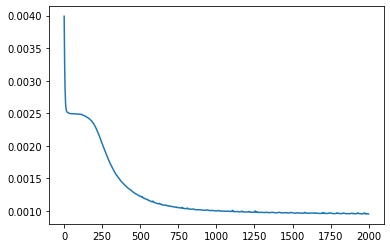

In [15]:
plt.plot(loss_tracker)

i:76 state is 76, action is Right, next state is 17
fc predicts next state to be 76


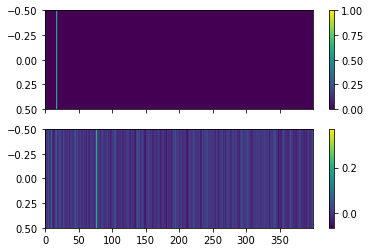

In [21]:
for x in range(1):
    index = np.random.choice(1)
    state = states[index]
    action = actions[index]
    n_state = n_states[index]

    phi, __, rec = fc(state,action)


    fig, ax = plt.subplots(2,1,sharex=True)
    p = ax[0].imshow(n_state, aspect='auto')
    fig.colorbar(p, ax=ax[0])
    
    phi = phi.detach().numpy()
    
    n_pred = rec.detach().numpy()
    q = ax[1].imshow(n_pred, aspect='auto')
    fig.colorbar(q, ax=ax[1])

    print(f'i:{index} state is {np.where(state==1)[1][0]}, action is {env.action_list[np.where(action==1)[1][0]]}, next state is {np.where(n_state==1)[1][0]}')
    print(f'fc predicts next state to be {np.where(n_pred == np.amax(n_pred))[1][0]}')
    plt.show()

In [66]:
class ACNet(nn.Module):
    def __init__(self):
        super(ACNet, self).__init__()
        num_actions = 4
        self.l1 = nn.Linear(400, 200)
        self.l2 = nn.Linear(200, 100)
        self.actor = nn.Linear(100,num_actions)
        self.critic = nn.Linear(100, 1)
        
        self.saved_logprob = []
        self.saved_values  = []
        self.saved_rewards = []
        
        self.optimizer = torch.optim.Adam(self.parameters(), lr=1e-2)
        
    def forward(self, state):
        x = torch.Tensor(state)
        
        x = F.relu(self.l1(x))
        
        x = F.relu(self.l2(x))
        
        pol = F.softmax(self.actor(x), 1)
        val = self.critic(x)
        
        return pol, val
    
    def discount_rwds(self, r, gamma = 0.99):
        disc_rwds = np.zeros_like(r)
        running_add = 0
        for t in reversed(range(0, r.size)):
            running_add = running_add*gamma + r[t]
            disc_rwds[t] = running_add
        return disc_rwds
    
    def finish_trial(self):
        returns = self.discount_rwds(np.asarray(self.saved_rewards))
        values = self.saved_values
        log_probs = self.saved_logprob
        
        pol_loss = 0
        val_loss = 0
          
        for G, V, P  in zip(returns, values, log_probs):
            G_t = G
            V_t = V
            log_prob = P
            
            delta = G_t - V_t.item()
            pol_loss += -log_prob * delta
            G_t = torch.Tensor([G_t])
            v_loss = torch.nn.L1Loss()(V_t, G_t)
            val_loss += v_loss
            
        self.optimizer.zero_grad()
        total_loss = pol_loss + val_loss
        total_loss.backward()
        self.optimizer.step()
        
        del self.saved_logprob[:]
        del self.saved_values[:]
        del self.saved_rewards[:]
        
        return pol_loss, val_loss

In [67]:
ac = ACNet()
r_track = []
l_track = [[],[]]

In [68]:
N_TRIALS = 1000
N_EVENTS = 250

for trial in range(N_TRIALS):
    env.reset()
    total_reward = 0

    for event in range(N_EVENTS):
        # get state
        state = env.get_observation(onehot=True)[0]
        # pass states to fc to get state representation
        dummy_action = np.expand_dims(np.array([1,0,0,0]),0)
        phi, _, __ = fc(state, dummy_action)
        # pass representation to ac
        pol, val = ac(phi)

        # get actions from ac policy
        a = Categorical(pol)
        action = a.sample()
        logprob = a.log_prob(action)
        value = val.view(-1)
        # step in the environment
        next_state, reward, done, info = env.step(action)
        # save reward, log prob, value 
        ac.saved_logprob.append(logprob)
        ac.saved_values.append(value)
        ac.saved_rewards.append(reward)

        total_reward += reward

        if done:
            break
    # end of trial, compute returns, compute loss, perform update 
    p, v = ac.finish_trial()
    r_track.append(total_reward)
    l_track[0].append(p)
    l_track[1].append(v)
    
    if trial%10==0: 
        print(f'Trial: {trial} Total Reward:{total_reward}')

Trial: 0 Total Reward:9.209999999999999
Trial: 10 Total Reward:9.24
Trial: 20 Total Reward:-2.4999999999999907
Trial: 30 Total Reward:-2.4999999999999907
Trial: 40 Total Reward:9.34


KeyboardInterrupt: 

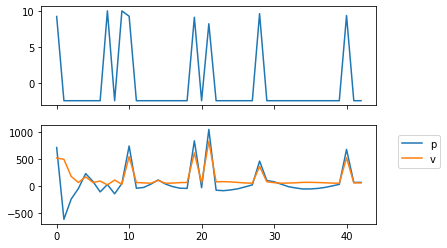

In [69]:
fig, ax = plt.subplots(2,1,sharex=True)
ax[0].plot(r_track)
ax[1].plot(l_track[0], label='p')
ax[1].plot(l_track[1], label='v')
ax[1].legend(bbox_to_anchor=(1.05,0.95))

In [84]:
states = []

for i in range(env.nstates):
    env.set_state(i)
    state = env.get_observation(onehot=True, agtlocation=i)[0]
    states.append(state)

In [85]:
phis = []
dummy_action = [np.expand_dims(np.array([1,0,0,0]),0) for x in range(len(states))]
phi, _, __ = fc(states, dummy_action)

In [86]:
d = np.zeros((env.nstates, env.nstates))
for i, p in enumerate(phi):
    a = p.detach().numpy()[0]
    for j, q in enumerate(phi):
        b = q.detach().numpy()[0]
        dist = np.linalg.norm(a-b)
        d[i,j] = dist
        

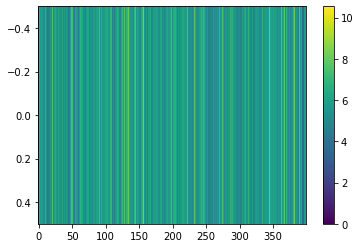

In [87]:
fig, ax = plt.subplots(1,1)
p = ax.imshow([d[0]], aspect='auto')
fig.colorbar(p, ax=ax)
plt.show()

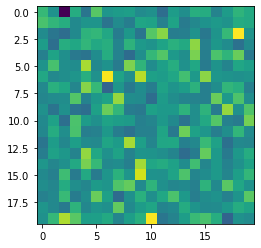

In [90]:
index_of_interest = 2
asgrid = np.zeros((env.r, env.c))
for i, item in enumerate(d[index_of_interest]):
    s_c, s_r = env.oneD2twoD(i)
    asgrid[s_c, s_r] = item
    
plt.imshow(asgrid)